# Import Libraries

In [4]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_opening, binary_closing, skeletonize
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from skimage import img_as_ubyte

# Helper Functions

In [ ]:
def show_images(test_cases, titles=None):
    """Display images in a 2x3 grid"""
    num_cases = len(test_cases)
    rows = (num_cases + 2) // 3  # Calculate rows needed
    cols = min(3, num_cases)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    axes = axes.flatten()
    
    for idx, img in enumerate(test_cases):
        if len(img.shape) == 2:  # Grayscale
            axes[idx].imshow(img, cmap='gray')
        else:  # Color
            axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        title = titles[idx] if titles else f"Case {idx + 1}"
        axes[idx].set_title(title)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(num_cases, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
def show_histograms(images, titles=None, bins=256):
    """Display histograms for a list of images in a 2x3-like grid (up to 3 columns)."""
    num = len(images)
    rows = (num + 2) // 3
    cols = min(3, num)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    axes = axes.flatten()

    for idx, im in enumerate(images):
        ax = axes[idx]
        if im.ndim == 2:  # grayscale
            ax.hist(im.ravel(), bins=bins, color='k')
            ax.set_ylabel('Count')
        else:  # color (BGR from cv2)
            colors = ('b', 'g', 'r')
            for c_idx, c in enumerate(colors):
                ax.hist(im[..., c_idx].ravel(), bins=bins, color=c, alpha=0.6, label=c)
            ax.legend(title='Channel')
            ax.set_ylabel('Count')

        ax.set_xlim(0, 255)
        ax.set_xlabel('Pixel value')
        title = (titles[idx] if titles else f"Case {idx+1}")
        ax.set_title(title)

    # Hide unused axes
    for j in range(num, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_case_stats(means, stds=None, titles=None, rows=2, cols=3, figsize=(12, 6), ylabel="Diameter (µm)"):
    """Plot per-case mean ± std in a rows x cols grid.

    Parameters
    - means: sequence of mean values (can contain np.nan)
    - stds: sequence of std values (same length as means) or None
    - titles: optional list of titles for each subplot
    - rows, cols: grid layout
    """
    import numpy as _np
    import matplotlib.pyplot as _plt

    n = len(means)
    fig, axes = _plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    # Determine y-limit from valid means
    valid_means = [m for m in means if not _np.isnan(m)]
    max_mean = max(valid_means) if valid_means else 1.0

    for idx in range(rows * cols):
        ax = axes[idx]
        if idx < n:
            m = means[idx]
            sd = stds[idx] if (stds is not None and idx < len(stds)) else 0
            title = titles[idx] if (titles is not None and idx < len(titles)) else f"Case {idx+1}"

            if _np.isnan(m):
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.bar(0, m, yerr=sd, capsize=5, color='C0')
                ax.set_xlim(-0.5, 0.5)
                ax.set_ylim(0, max_mean * 1.2)
                ax.set_xticks([])
                ax.set_ylabel(ylabel)
                ax.set_title(f"{title}\nmean={m:.1f} µm\nstd={sd:.1f} µm")
        else:
            ax.axis('off')

    _plt.tight_layout()
    _plt.show()

def diameter_profile(mask_bin, um_per_px):
    """
    mask_bin: cleaned binary mask (0/1)
    returns: diameters in micrometers along the silk
    """
    # Distance transform on foreground
    dist = distance_transform_edt(mask_bin)

    # Skeleton
    skel = skeletonize(mask_bin.astype(bool))

    # Distances on skeleton → radius
    radii_px = dist[skel]
    diam_px = 2.0 * radii_px
    diam_um = diam_px * um_per_px
    return diam_um

def enforce_two_bg_one_silk(core, uncertainty):
    """
    Enforce exactly two background regions and one connected silk region.
    Inputs:
      - core, uncertainty: boolean or 0/1 numpy arrays of the same shape
            - as_line: if True, return a single-pixel-per-row vertical center line of the silk
    Returns:
      - final_silk_uint8, final_bg_uint8, (n_bg_final, n_silk_final)
    """
    band_raw = core | uncertainty
    from scipy.ndimage import binary_fill_holes, distance_transform_edt

    bg_orig = (~band_raw).astype(bool)

    # Helper: get components sorted by area (largest first)
    def sorted_components(mask):
        lbl = label(mask)
        comps = []
        for lab in range(1, lbl.max() + 1):
            comp = (lbl == lab)
            comps.append((int(comp.sum()), comp))
        comps.sort(key=lambda x: x[0], reverse=True)
        return comps

    # 1) Pick two largest background components from the original background if possible
    areas_o = sorted_components(bg_orig)
    if len(areas_o) >= 2:
        bg1 = areas_o[0][1].copy()
        bg2 = areas_o[1][1].copy()
        final_bg = bg1 | bg2
    else:
        # Fallback: progressively close background until we can get two components
        bg = bg_orig.copy()
        radius = 1
        max_radius = max(bg.shape) // 4
        while True:
            comps = sorted_components(bg)
            if len(comps) >= 2:
                bg1 = comps[0][1].copy()
                bg2 = comps[1][1].copy()
                final_bg = bg1 | bg2
                break
            if radius > max_radius:
                # last-resort: split left/right
                h, w = bg.shape
                final_bg = np.zeros_like(bg)
                final_bg[:, :w//4] = True
                final_bg[:, -w//4:] = True
                bg1 = final_bg & (np.arange(final_bg.shape[1]) < final_bg.shape[1]//2)
                bg2 = final_bg & (np.arange(final_bg.shape[1]) >= final_bg.shape[1]//2)
                break
            bg = binary_closing(bg, disk(radius))
            bg = binary_fill_holes(bg)
            radius += 1

    # 2) Silk is complement of the two chosen background regions
    final_silk = ~final_bg
    final_silk = binary_fill_holes(final_silk)

    # 3) Ensure silk is a single connected component: if fragmented, keep largest as silk and reassign other fragments to nearest background
    lbl_silk = label(final_silk)
    if lbl_silk.max() > 1:
        # identify largest silk component
        silk_comps = sorted_components(final_silk)
        main_silk = silk_comps[0][1].copy()
        other_silk = np.zeros_like(final_silk, dtype=bool)
        for _, comp in silk_comps[1:]:
            other_silk |= comp

        # compute distance maps to the two background regions
        dist_bg1 = distance_transform_edt(~bg1)
        dist_bg2 = distance_transform_edt(~bg2)

        # assign each pixel of other_silk to the nearer background
        assign_to_bg1 = (dist_bg1 < dist_bg2) & other_silk
        assign_to_bg2 = (dist_bg2 <= dist_bg1) & other_silk

        bg1 |= assign_to_bg1
        bg2 |= assign_to_bg2

        # rebuild final background and silk
        final_bg = bg1 | bg2
        final_silk = ~final_bg
        final_silk = binary_fill_holes(final_silk)

    # 4) As a safety, if final_silk ended up empty, fall back to filling holes within original band
    if final_silk.sum() == 0:
        final_silk = binary_fill_holes(band_raw.astype(bool))
        # if still empty, keep original core
        if final_silk.sum() == 0:
            final_silk = core.astype(bool)

    # Diagnostics
    n_bg_final = label(final_bg).max()
    n_silk_final = label(final_silk).max()

    return final_silk.astype(np.uint8), final_bg.astype(np.uint8), (n_bg_final, n_silk_final)

def compute_skeleton(mask, method='centerline', smooth_window=11, width=1, closing_height=3):
    """Compute a 1-pixel-wide skeleton for a binary mask.

    Parameters
    - mask: 2D array-like (0/1 or bool)
    - method: 'skeletonize' to use skimage.skeletonize, or 'centerline' to compute
              a single-pixel-per-row centerline then skeletonize it.
    - smooth_window: integer odd window for smoothing the per-row center x coordinates
    - width: if >1, widen the centerline horizontally before skeletonizing
    - closing_height: vertical closing size to fill tiny gaps in the line

    Returns
    - boolean array same shape as mask containing the skeleton
    """
    m = mask.astype(bool)
    if method == 'skeletonize':
        return skeletonize(m).astype(bool)

    # centerline method
    h, w = m.shape
    xs = np.full(h, np.nan)
    for y in range(h):
        cols = np.nonzero(m[y, :])[0]
        if cols.size:
            xs[y] = np.median(cols)

    # If no rows contained silk, return empty skeleton
    if not np.isfinite(xs).any():
        return np.zeros_like(m, dtype=bool)

    # Interpolate missing rows
    rows = np.arange(h)
    good = np.isfinite(xs)
    if not good.all():
        xs[~good] = np.interp(rows[~good], rows[good], xs[good])

    # Smooth x positions with a simple moving average
    if smooth_window is None or smooth_window <= 1:
        xs_smooth = xs
    else:
        k = np.ones(smooth_window) / float(smooth_window)
        xs_smooth = np.convolve(xs, k, mode='same')

    xs_int = np.clip(np.round(xs_smooth).astype(int), 0, w - 1)

    line = np.zeros((h, w), dtype=bool)
    line[rows, xs_int] = True

    # Fill tiny vertical gaps with a narrow vertical closing
    try:
        from skimage.morphology import binary_closing, rectangle, dilation
        line = binary_closing(line, rectangle(closing_height, 1))
    except Exception:
        # fallback: simple interpolation of isolated missing rows
        for y in range(1, h - 1):
            if not line[y].any() and line[y - 1].any() and line[y + 1].any():
                cx_prev = int(np.round(np.nonzero(line[y - 1])[0].mean()))
                cx_next = int(np.round(np.nonzero(line[y + 1])[0].mean()))
                cx = int(np.round((cx_prev + cx_next) / 2.0))
                if 0 <= cx < w:
                    line[y, cx] = True

    # Optionally widen before skeletonizing
    if width is not None and width > 1:
        try:
            from skimage.morphology import dilation, rectangle
            line = dilation(line, rectangle(1, width))
        except Exception:
            pad = width // 2
            new = np.zeros_like(line)
            for y in range(h):
                x = xs_int[y]
                l = max(0, x - pad)
                r = min(w, x + pad + 1)
                new[y, l:r] = True
            line = new

    # Final skeletonize to ensure a 1-pixel-wide center
    sk = skeletonize(line)
    return sk.astype(bool)


def diameters_from_skeleton(skeleton, dist_map, um_per_px):
    """
    Compute local diameters along a 1-pixel-wide skeleton using
    a Euclidean distance transform.

    Parameters
    ----------
    skeleton : 2D np.ndarray of bool or 0/1
        Skeleton mask: True/1 on the centreline, False/0 elsewhere.
    dist_map : 2D np.ndarray of float
        Euclidean distance transform of the *same* binary mask
        used to create the skeleton. Each pixel = distance [px]
        to nearest background.
    um_per_px : float, optional
        Scale factor to convert pixels to micrometres.

    Returns
    -------
    diam_px : 1D np.ndarray
        Local diameters in pixels at each skeleton pixel.
    diam_um : 1D np.ndarray
        Same diameters in micrometres.
    stats : dict
        Summary statistics (mean, std, min, max in µm).
    """

    # Ensure boolean skeleton
    skel_bool = skeleton.astype(bool)

    # Radii at skeleton pixels (in pixels)
    radii_px = dist_map[skel_bool]

    # Filter out zeros just in case (edge artefacts)
    radii_px = radii_px[radii_px > 0]

    diam_px = 2.0 * radii_px
    diam_um = diam_px * um_per_px

    stats = {
        "mean_um": float(diam_um.mean()) if diam_um.size else np.nan,
        "std_um":  float(diam_um.std())  if diam_um.size else np.nan,
        "min_um":  float(diam_um.min())  if diam_um.size else np.nan,
        "max_um":  float(diam_um.max())  if diam_um.size else np.nan,
        "n_points": int(diam_um.size),
    }

    return diam_px, diam_um, stats

def analyze_band(band_mask, otsu_regions, treat_remainder='bg'):
    """Analyze a single detected band.

    Parameters
    - band_mask: 2D boolean or 0/1 array selecting the detected band (True inside band)
    - otsu_regions: 2D integer array with Otsu classes (0=pure silk,1=uncertainty,2=background)
    - treat_remainder: 'bg' to assign unlabeled pixels to background, 'other' to keep them separate

    Returns
    - result: dict with counts, percentages, masks and an overlay image (BGR uint8)
    """
    band = np.asarray(band_mask).astype(bool)
    regs = np.asarray(otsu_regions)

    h, w = band.shape
    band_area = int(band.sum())

    pure_mask = band & (regs == 0)
    unc_mask = band & (regs == 1)
    bg_mask = band & (regs == 2)

    c_pure = int(pure_mask.sum())
    c_unc = int(unc_mask.sum())
    c_bg = int(bg_mask.sum())

    remainder = band_area - (c_pure + c_unc + c_bg)
    c_other = 0
    other_mask = None
    if remainder > 0:
        other_mask = band & ~(pure_mask | unc_mask | bg_mask)
        c_other = int(other_mask.sum())
        if treat_remainder == 'bg':
            c_bg += c_other
            c_other = 0
            other_mask = None

    # Percentages (relative to band_area which we treat as 100%)
    if band_area > 0:
        p_pure = c_pure / band_area * 100.0
        p_unc = c_unc / band_area * 100.0
        p_bg = c_bg / band_area * 100.0
        p_other = c_other / band_area * 100.0
    else:
        p_pure = p_unc = p_bg = p_other = 0.0

    # Create overlay (BGR) for visualization
    overlay = np.zeros((h, w, 3), dtype=np.uint8)
    overlay[pure_mask] = [0, 255, 0]   # green
    overlay[unc_mask]  = [255, 0, 0]   # blue
    overlay[bg_mask]   = [0, 0, 255]   # red
    if other_mask is not None:
        overlay[other_mask] = [0, 255, 255]  # yellow-ish for other

    result = {
        'band_area': band_area,
        'counts': {'pure': c_pure, 'uncertainty': c_unc, 'background': c_bg, 'other': c_other},
        'percent': {'pure': p_pure, 'uncertainty': p_unc, 'background': p_bg, 'other': p_other},
        'masks': {'pure': pure_mask, 'uncertainty': unc_mask, 'background': bg_mask, 'other': other_mask},
        'overlay': overlay,
    }
    return result


def plot_band_composition(results, titles=None, figsize=(10,4), ylabel='Percentage of band (%)'):
    """Plot stacked percent bars for a list of analyze_band results or simple dicts.

    Parameters
    - results: list of dicts returned by `analyze_band` or dict-like with keys 'percent' or counts
    - titles: optional list of labels for x-axis
    - figsize: figure size

    Returns
    - fig, ax: matplotlib objects
    """
    import matplotlib.pyplot as _plt
    import numpy as _np

    # Extract percentages (ensure order: pure, uncertainty, background, other)
    pure = []
    unc = []
    bg = []
    other = []
    for r in results:
        if 'percent' in r:
            pct = r['percent']
            pure.append(pct.get('pure', 0.0))
            unc.append(pct.get('uncertainty', 0.0))
            bg.append(pct.get('background', 0.0))
            other.append(pct.get('other', 0.0))
        elif 'counts' in r and 'band_area' in r:
            # fallback: compute from counts
            t = r['band_area'] if r['band_area']>0 else 1
            c = r['counts']
            pure.append(c.get('pure',0)/t*100.0)
            unc.append(c.get('uncertainty',0)/t*100.0)
            bg.append(c.get('background',0)/t*100.0)
            other.append(c.get('other',0)/t*100.0)
        else:
            pure.append(0.0); unc.append(0.0); bg.append(0.0); other.append(0.0)

    n = len(pure)
    labels = titles if titles is not None else [f"Case {i+1}" for i in range(n)]
    x = _np.arange(n)
    width = 0.6

    fig, ax = _plt.subplots(figsize=figsize)
    ax.bar(x, pure, width, label='Pure silk', color='C2')
    ax.bar(x, unc, width, bottom=_np.array(pure), label='Uncertainty (translucency, possibly liquid)', color='C0')
    bottom_bg = _np.array(pure) + _np.array(unc)
    ax.bar(x, bg, width, bottom=bottom_bg, label='Background (reflection, probably solid)', color='C1')
    # if there is an 'other' component, plot it on top
    if any(o > 0 for o in other):
        bottom_other = bottom_bg + _np.array(bg)
        ax.bar(x, other, width, bottom=bottom_other, label='Other', color='C3')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 100)
    ax.set_title('Band composition (percent)')
    ax.legend()
    _plt.tight_layout()
    _plt.show()
    return fig, ax



# 1. Load images and show histogram

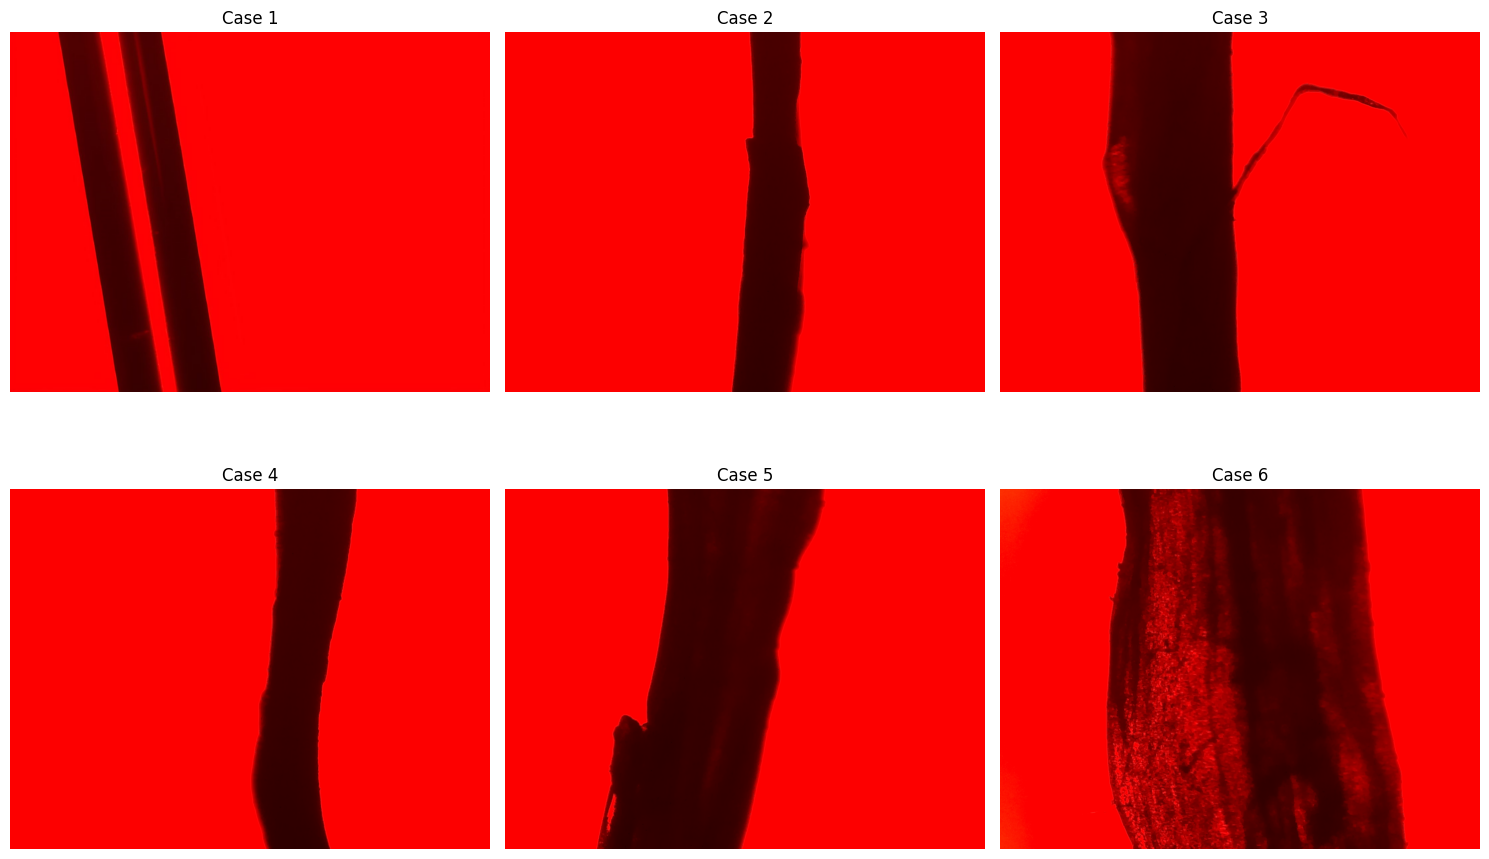

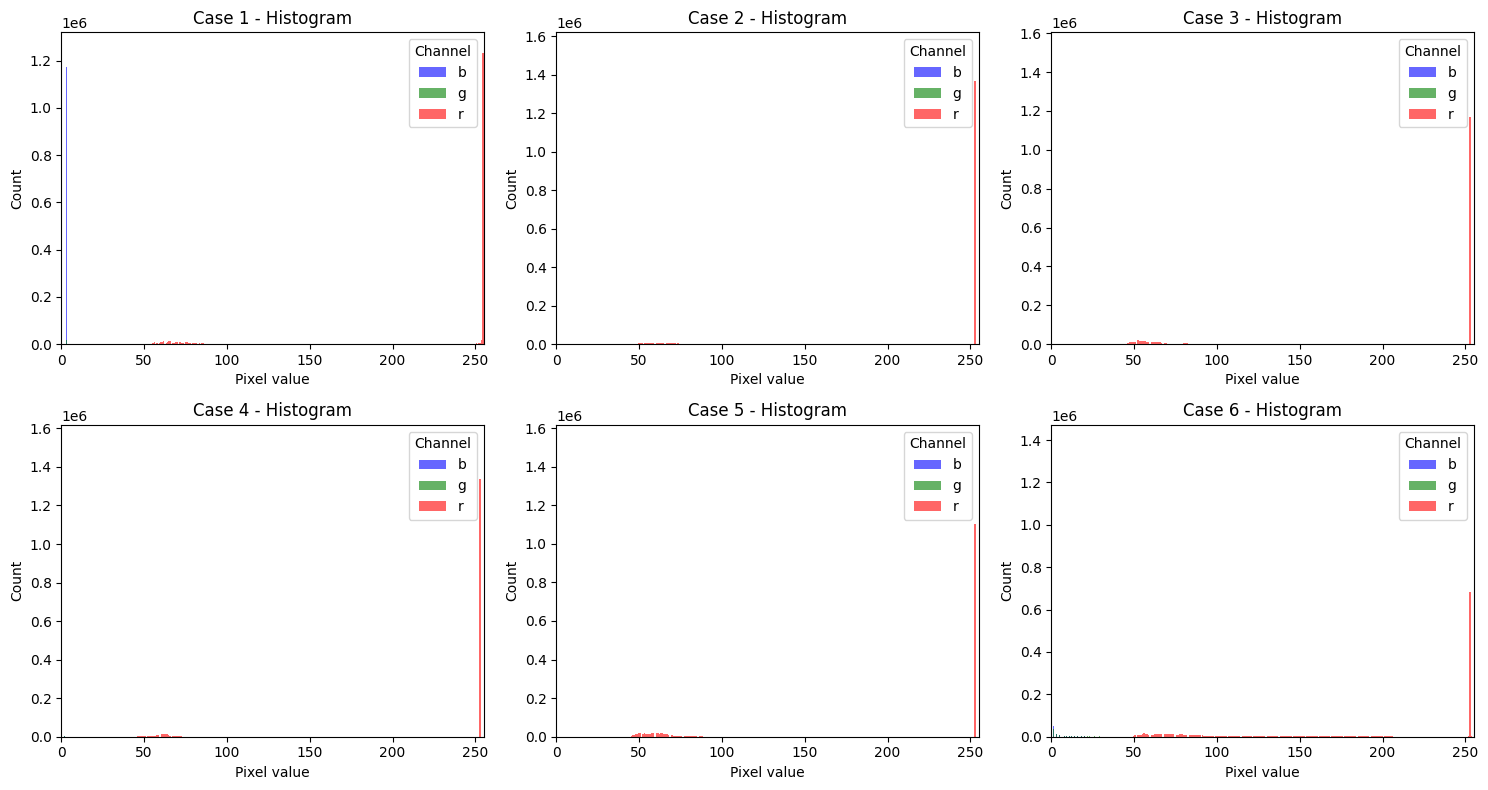

In [6]:
# Load test images using PIL
test_cases = []
for i in range(1, 7):
    img = Image.open(f'{i}.png')
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    test_cases.append(img_cv)

# Display original images
show_images(test_cases, titles=[f"Case {i+1}" for i in range(len(test_cases))])

# Show histograms
show_histograms(test_cases, titles=[f"Case {i+1} - Histogram" for i in range(len(test_cases))])

# 2. Greyscale and Crop

Cropping images to 300 pixels height. The original image height is 1080 pixels.


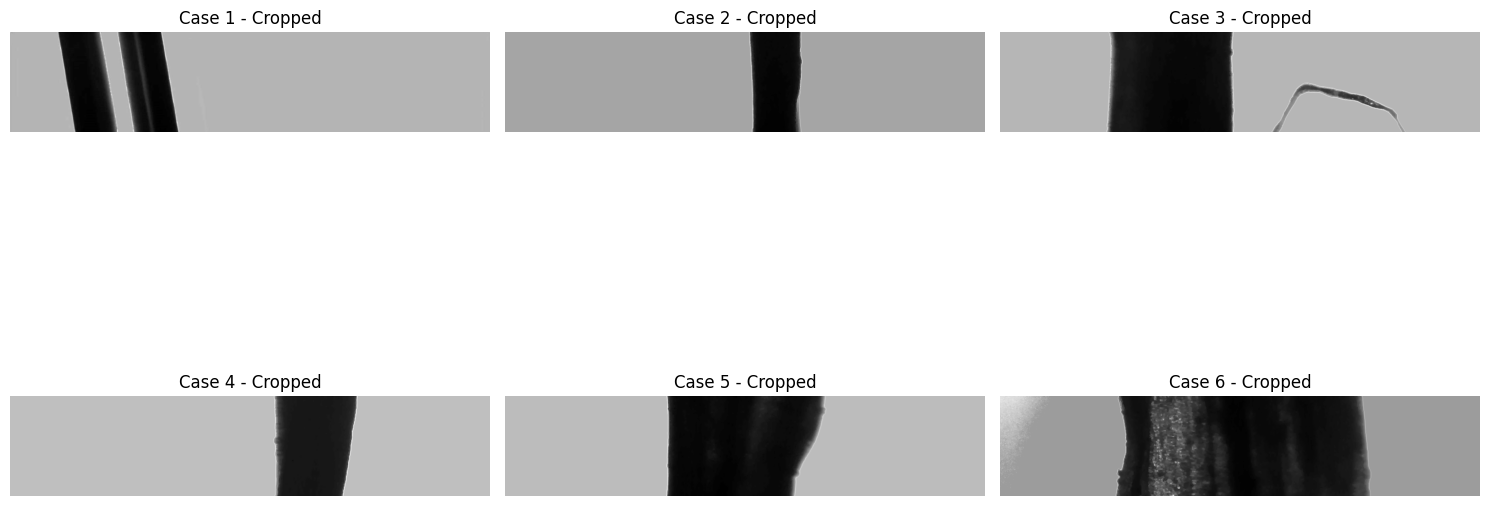

In [7]:
# Crop images to slice_size_px height, keeping full width
slice_size_mm = 0.25;
um_per_px = 1.2;  # Example conversion factor, adjust as needed
slice_size_px = int(slice_size_mm * 1000 * um_per_px);
print(f"Cropping images to {slice_size_px} pixels height. The original image height is {test_cases[0].shape[0]} pixels.")

test_cases_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in test_cases]
test_cases_gray_cropped = [img[:slice_size_px, :] for img in test_cases_gray]
show_images(test_cases_gray_cropped, titles=[f"Case {i+1} - Cropped" for i in range(len(test_cases_gray_cropped))])

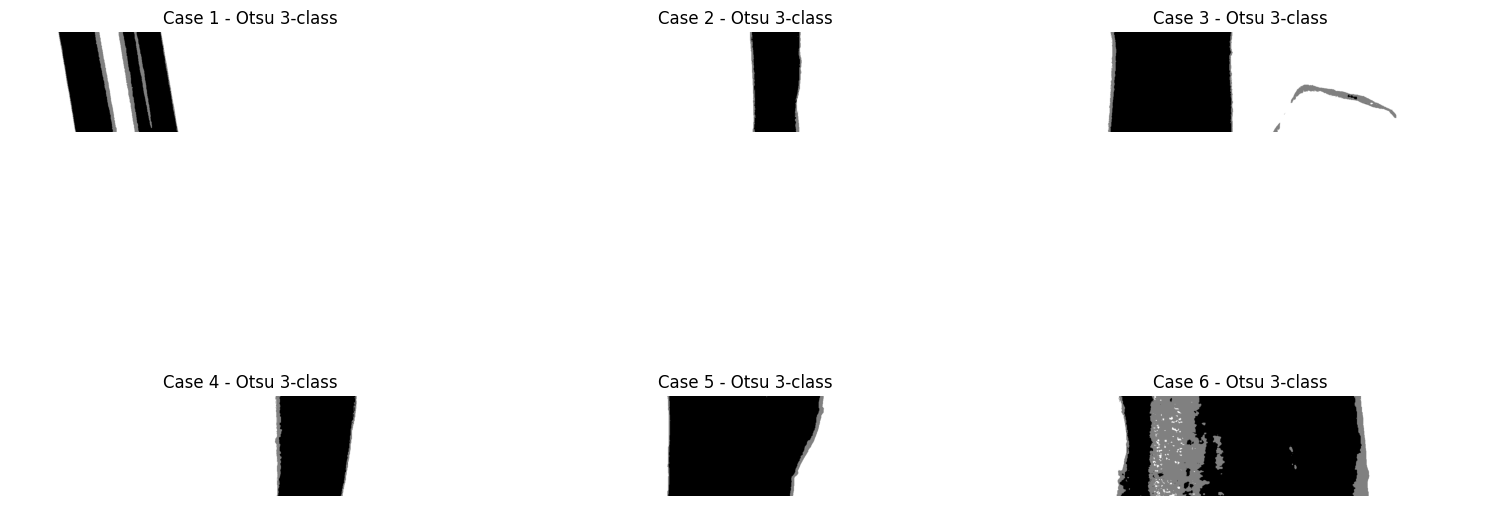

In [8]:
# Apply 3-class Otsu to cropped grayscale images
test_cases_otsu3 = []
for img in test_cases_gray_cropped:
    thresholds = threshold_multiotsu(img, classes=3)
    regions = np.digitize(img, bins=thresholds)
    test_cases_otsu3.append(regions)

show_images(test_cases_otsu3, titles=[f"Case {i+1} - Otsu 3-class" for i in range(len(test_cases_otsu3))])

# 3. Example Segment

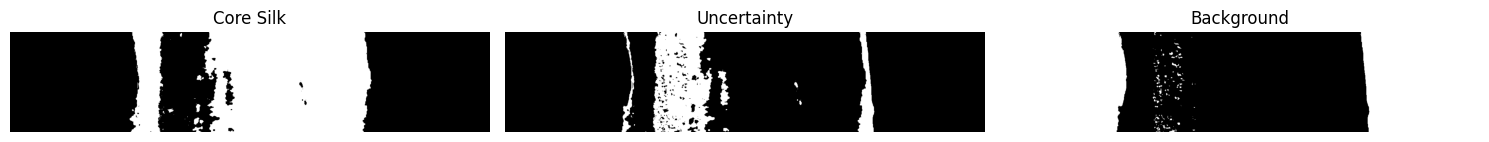

In [9]:
core = (regions == 0)       # sure silk
uncertainty = (regions == 1)       # uncertainty (gray)
background   = (regions == 2)       # background
show_images([core, uncertainty, background],
            titles=["Core Silk", "Uncertainty", "Background"])

# 4. Fill the small holes, to measure properly the diameter

Final background components: 2, Final silk components: 1


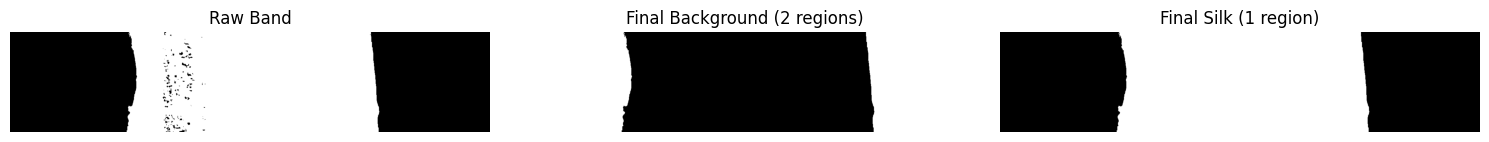

In [10]:
# Request a single somewhat-vertical center line for the silk
final_silk, final_bg, (n_bg_final, n_silk_final) = enforce_two_bg_one_silk(core, uncertainty)
print(f"Final background components: {n_bg_final}, Final silk components: {n_silk_final}")

show_images([core | uncertainty, final_bg.astype(np.uint8), final_silk.astype(np.uint8)],
            titles=["Raw Band", "Final Background (2 regions)", "Final Silk (1 region)"])

# Update band variable used later
band = final_silk.astype(bool)

# 5. Show the band for all of the pictures.

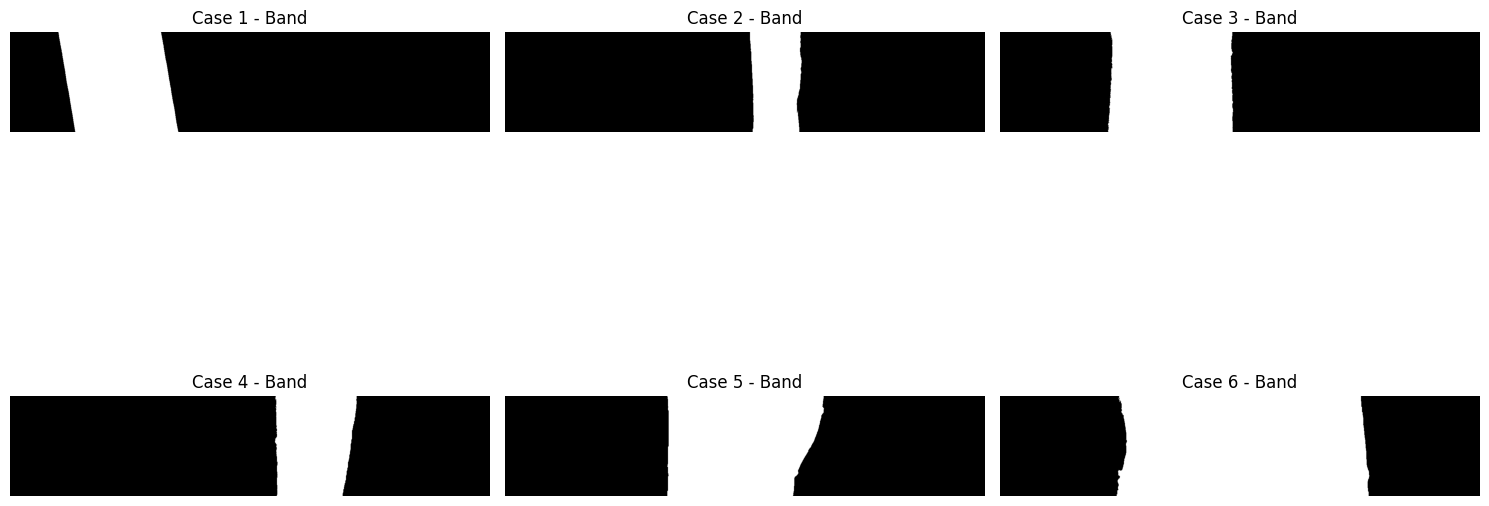

In [11]:
# Apply 3-class Otsu to cropped grayscale images
test_cases_band = []
for img in test_cases_otsu3:
    core = (img == 0)       # sure silk
    uncertainty = (img == 1)       # uncertainty (gray)
    background   = (img == 2)       # background
    final_silk, final_bg, (n_bg_final, n_silk_final) = enforce_two_bg_one_silk(core, uncertainty)
    test_cases_band.append(final_silk)

show_images(test_cases_band, titles=[f"Case {i+1} - Band" for i in range(len(test_cases_otsu3))])

# 6. Skeletonize

/tmp/ipykernel_3839/3811447719.py:317: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  line = binary_closing(line, rectangle(closing_height, 1))


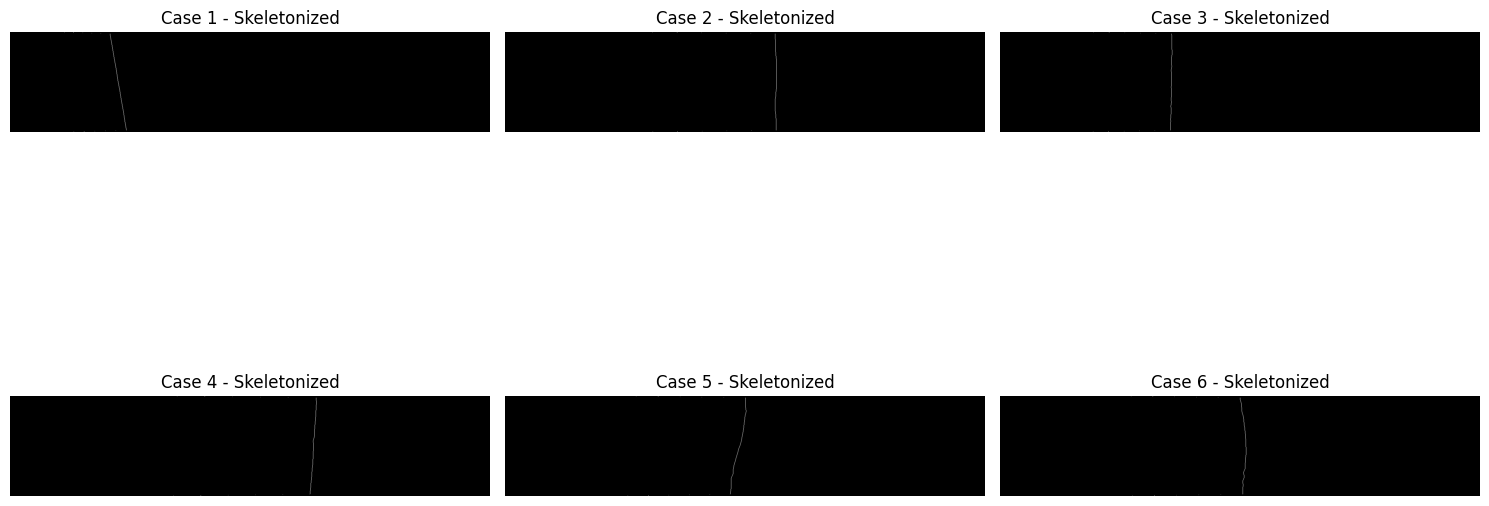

In [12]:
# Apply 3-class Otsu to cropped grayscale images
test_cases_skeletonized = []
for img in test_cases_band:
    skeleton = compute_skeleton(img)
    test_cases_skeletonized.append(skeleton)

show_images(test_cases_skeletonized, titles=[f"Case {i+1} - Skeletonized" for i in range(len(test_cases_otsu3))])


# 7. Perform a distance transform

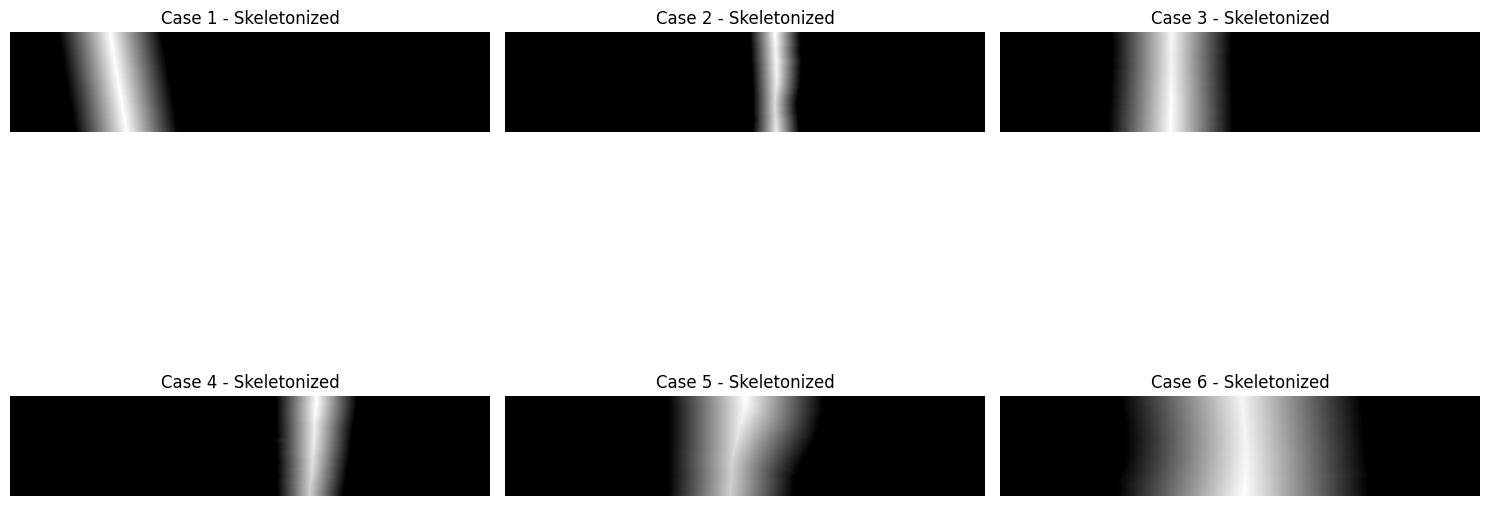

In [13]:
test_cases_dist = []
for img in test_cases_band:
    dist = distance_transform_edt(img)
    test_cases_dist.append(dist)

show_images(test_cases_dist, titles=[f"Case {i+1} - Skeletonized" for i in range(len(test_cases_otsu3))])


# 8. Calculate the diameter stats

Per-case stats:
{'case': 1, 'mean_um': 356.77225333116144, 'std_um': 41.980013246088625, 'n_points': 301}
{'case': 2, 'mean_um': 168.05983242108337, 'std_um': 13.076773491495707, 'n_points': 291}
{'case': 3, 'mean_um': 426.29462170263145, 'std_um': 48.499414692665745, 'n_points': 298}
{'case': 4, 'mean_um': 260.4643460851769, 'std_um': 23.23108526373198, 'n_points': 292}
{'case': 5, 'mean_um': 470.84332390215127, 'std_um': 56.55757183055589, 'n_points': 296}
{'case': 6, 'mean_um': 838.9301843599283, 'std_um': 102.8264535255948, 'n_points': 302}


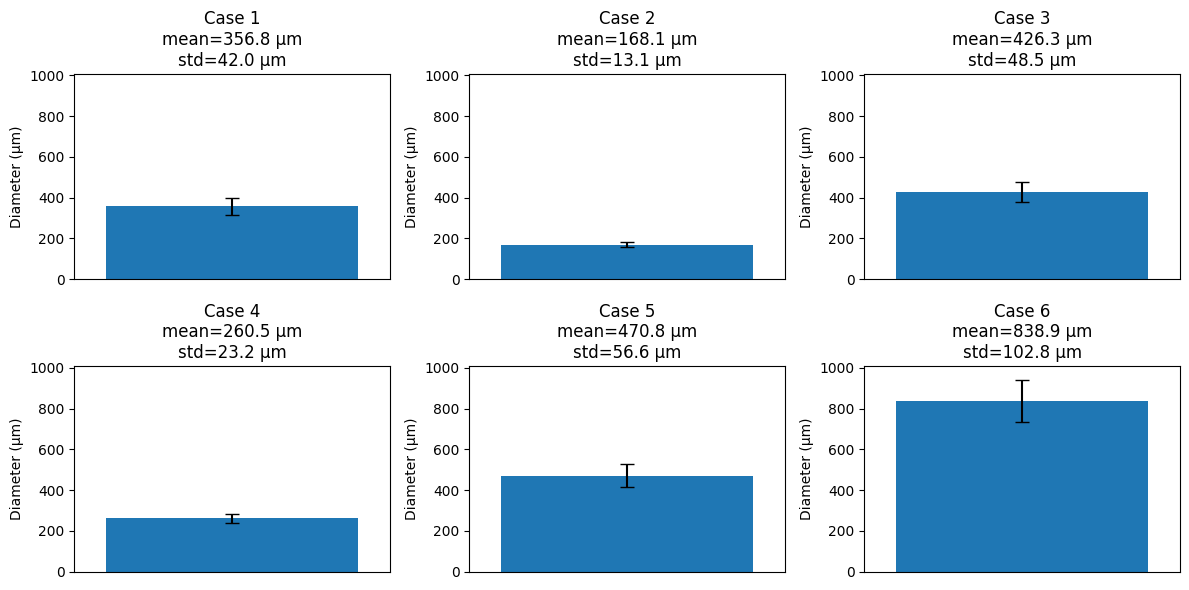

In [14]:
# Compute per-case diameter statistics (values gathered here; plotting delegated to helper)
means = []
stds = []
n_points = []

for i, (skel, dist) in enumerate(zip(test_cases_skeletonized, test_cases_dist)):
    diam_px, diam_um, stats = diameters_from_skeleton(skel, dist, um_per_px)
    means.append(stats["mean_um"])
    stds.append(stats["std_um"])
    n_points.append(stats["n_points"])

# Build a summary list of dicts
test_cases_stats = [
    {"case": i + 1, "mean_um": float(m) if not np.isnan(m) else np.nan, "std_um": float(s) if not np.isnan(s) else np.nan, "n_points": int(n)}
    for i, (m, s, n) in enumerate(zip(means, stds, n_points))
]

print("Per-case stats:")
for s in test_cases_stats:
    print(s)

# Plot using the reusable helper (keeps data collection separate)
plot_case_stats(means, stds, titles=[f"Case {i+1}" for i in range(len(means))])



# 9. Figure out the amount of solids

Case 1: band_area=92524 px — pure_silk=63995 px (69.2%), uncertainty=11916 px (12.9%), background=16613 px (18.0%)
Case 2: band_area=42594 px — pure_silk=39442 px (92.6%), uncertainty=3151 px (7.4%), background=1 px (0.0%)
Case 3: band_area=109134 px — pure_silk=104779 px (96.0%), uncertainty=4333 px (4.0%), background=22 px (0.0%)
Case 4: band_area=66476 px — pure_silk=61936 px (93.2%), uncertainty=4512 px (6.8%), background=28 px (0.0%)
Case 5: band_area=127217 px — pure_silk=122539 px (96.3%), uncertainty=4678 px (3.7%), background=0 px (0.0%)
Case 6: band_area=218495 px — pure_silk=161835 px (74.1%), uncertainty=54641 px (25.0%), background=2019 px (0.9%)


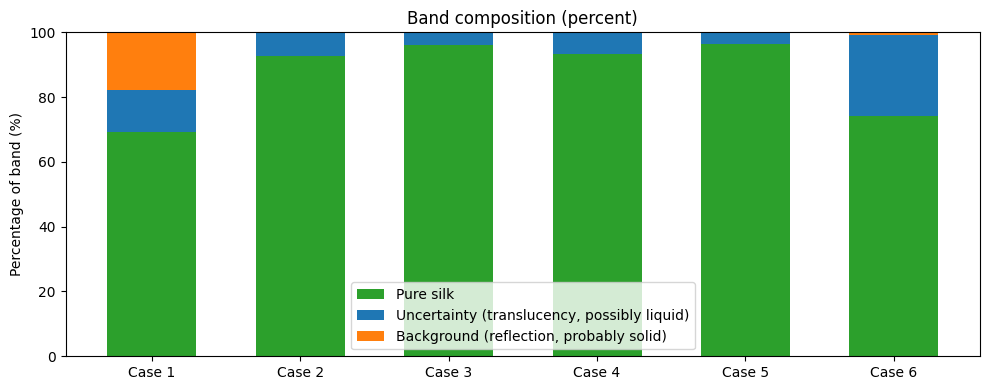

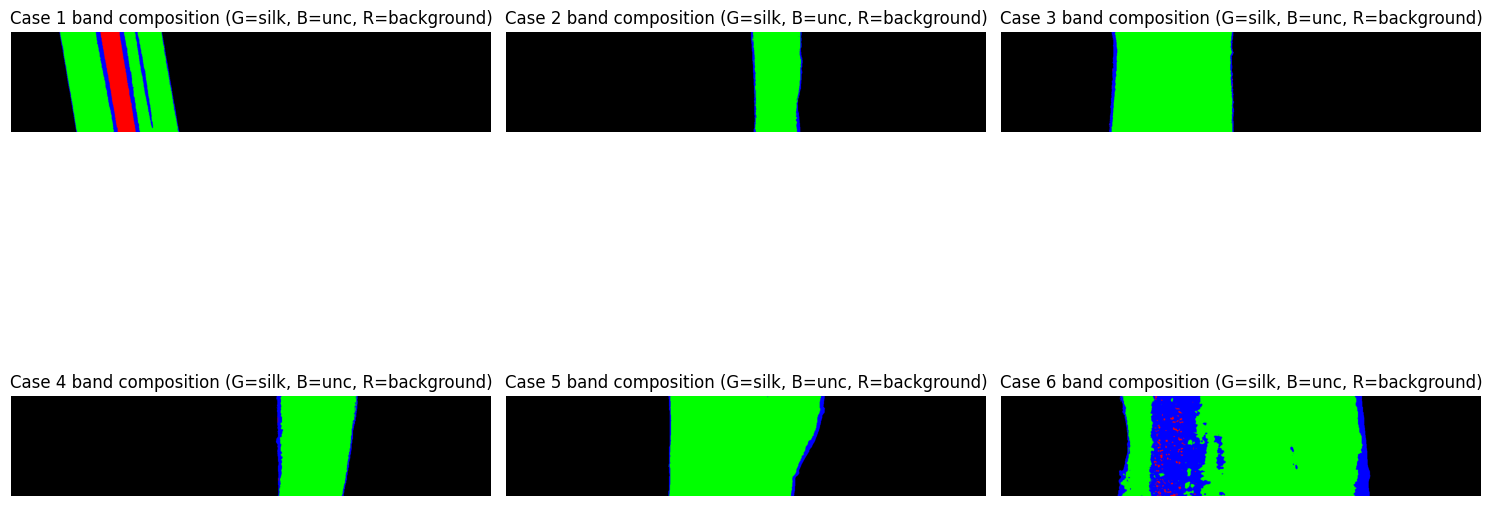

In [15]:
# Analyze each band using the helper and plot results with the plotting helper
results = [analyze_band(band, otsu, treat_remainder='bg') for band, otsu in zip(test_cases_band, test_cases_otsu3)]

# Print concise per-case summary
for i, r in enumerate(results):
    pa = r['band_area']
    pct = r['percent']
    print(f"Case {i+1}: band_area={pa} px — pure_silk={r['counts']['pure']} px ({pct['pure']:.1f}%), "
          f"uncertainty={r['counts']['uncertainty']} px ({pct['uncertainty']:.1f}%), "
          f"background={r['counts']['background']} px ({pct['background']:.1f}%)")

# Stacked percent plot (each bar = 100%)
plot_band_composition(results, titles=[f"Case {i+1}" for i in range(len(results))])

# Show overlays for visual inspection
show_images([r['overlay'] for r in results], titles=[f"Case {i+1} band composition (G=silk, B=unc, R=background)" for i in range(len(results))])
